# CO2 concentration in the atmosphere since 1958
Using the CO2 concentration measures from Mauna Loa, we suggest that this evolution is made of a periodic evolution and another component that is alarmly increasing.
We isolate the two components, then interpolate them to make predictions about the CO2 concentration of years to come.
- - -

First we run a Bash script that will check if the dataset is already in the folder. If it isn't, it gets dowloaded from [here](http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record).
Because the data is updated regurlarly, we add a timestamp in the file name to keep track of which version of the dataset we are working with.

In [1]:
%%bash

if [ ! -f weekly_in_situ_co2_mlo* ]; then
	echo "I can't find the dataset, I'm gonna download it!"
	wget "http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv" -O "weekly_in_situ_co2_mlo_$(date --rfc-3339 seconds).csv"
else
	echo "Dataset is already there, yay!"
fi

Dataset is already there, yay!


We then list the files in the folder and check the one with the expected suffix to get the actual file name.

In [2]:
import os

filename = next(x for x in os.listdir() if "weekly_in_situ_co2_mlo" in x)
print(filename)

weekly_in_situ_co2_mlo_2018-09-11 20:14:14+02:00.csv


Lets us take a look at this file.

In [3]:
%%bash
head -n 50 weekly_in_situ_co2_mlo*

"-------------------------------------------------------------------------------------------"
" Atmospheric CO2 concentrations (ppm) derived from in situ air measurements                "
" at Mauna Loa, Observatory, Hawaii: Latitude 19.5°N Longitude 155.6°W Elevation 3397m      "
"                                                                                           "
" Source: R. F. Keeling, S. J. Walker, S. C. Piper and A. F. Bollenbacher                   "
" Scripps CO2 Program ( http://scrippsco2.ucsd.edu )                                        "
" Scripps Institution of Oceanography (SIO)                                                 "
" University of California                                                                  "
" La Jolla, California USA 92093-0244                                                       "
"                                                                                           "
" Status of data and correspondence:                        

Now, we can import it as a Pandas dataframe. We know where the actual data start, and what the meaning of the different columns are. We can print the head of our dataframe to check we got things right.

In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv(filename, header=43, names=['Date', 'Concentration'], parse_dates=[0])
print(data.head())

        Date  Concentration
0 1958-03-29         316.19
1 1958-04-05         317.31
2 1958-04-12         317.69
3 1958-04-19         317.58
4 1958-04-26         316.48


The date format is not very convenient for plotting, so we will convert it to float. For the sake of simplicity, we use a convenient approximation, considering all years to be 366 days long.

In [5]:
dataYear = data['Date'].apply(lambda x: (float(x.strftime("%j")) - 1) / 366 + float(x.strftime("%Y")))
print(dataYear.head())

0    1958.237705
1    1958.256831
2    1958.275956
3    1958.295082
4    1958.314208
Name: Date, dtype: float64


Now, we can actually plot our dataset. Matplotlib will do it just fine for us. We add some fancy tweaks, and we get a nice chart.

In [6]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1, figsize=[12,4])
ax.plot(dataYear, data['Concentration'], c='#ce1256')
ax.set_xlabel("Year")
ax.set_ylabel("CO2 Concentration (ppm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<Figure size 1200x400 with 1 Axes>

We conjecture that this evolution is twofolds:
* a periodic oscillation (with, approximately, a 1 year period)
* a slower evolution
    
We use a high-pass filter to try to isolate the periodic component.

We first print the Fast Fourier Transform of the evolution.

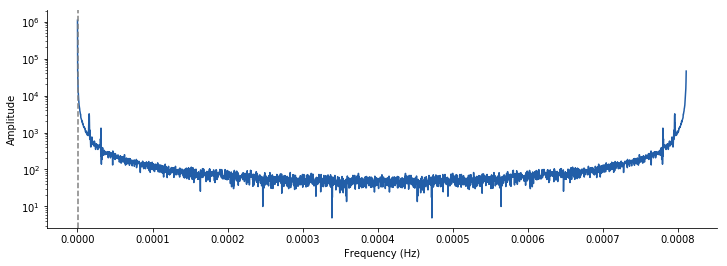

In [7]:
import scipy.signal # Signal Processing Library
array = data['Concentration']
array_fft = np.fft.fft(array) # getting the Fast Fourier Transform

fs = 1 / (7 * 24 * 3600) # this is the sample frequency, we have one measure per week

z = np.arange(0, len(array))
z = z * fs / 2 / np.pi # this is the x values in the frequency domain

f, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(z, np.abs(array_fft), c='#225ea8')
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.semilogy()

fe =  1 / (365 * 24 * 3600) # expected main frequency
ax.axvline(x=fe, c='gray', linestyle='--')

plt.show()


We indeed see a main periodic component in the signal around the frequency corresponding to a 1 year period.

We then apply a high-pass filter, to only keep the periodic component.

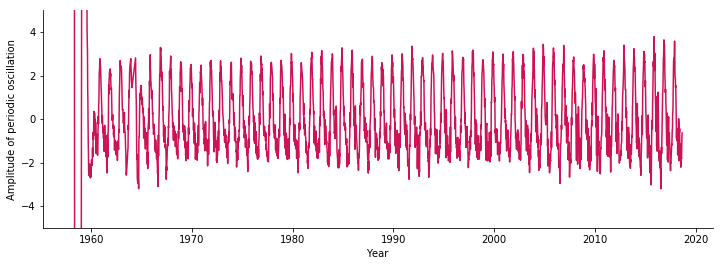

In [8]:
import scipy.signal # Signal Processing Library

order = 3
cutoff = 1 / (350 * 24 * 3600) # chosen empirically, close to the expected frequency
n_cutoff = cutoff / (fs * 0.5)

array = data['Concentration']
b, a = scipy.signal.butter(order, n_cutoff, btype='high', analog=False)
result = scipy.signal.lfilter(b, a, array)

f, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(dataYear, result, c='#ce1256')
ax.set_xlabel("Year")
ax.set_ylabel("Amplitude of periodic oscillation")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-5, 5])
plt.show()


Once again, it is clear that we have a 1 year period.

- - -

Thus, we can study the general increase in CO2 concentration by simply studying the evolution of each year.
For each year, we compute the mean, min, max and standard deviation of CO2 concentration.
We plot them on the following graph.

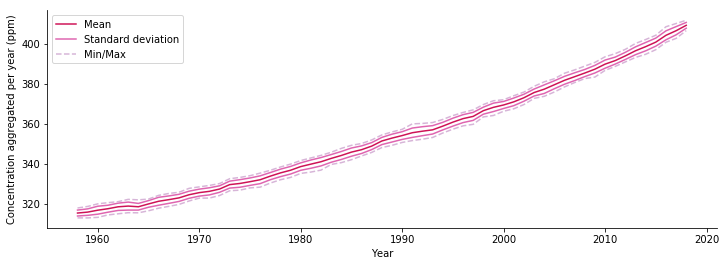

In [9]:
data['Year'] = data['Date'].apply(lambda x: int(x.strftime('%Y')))
data_agg = data.groupby(['Year']).agg(['mean', 'std', 'min', 'max'])

f, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(data_agg['Concentration']['mean'], c='#ce1256', label='Mean')
for i in [-1, 1]:
    ax.plot(data_agg['Concentration']['mean'] + i * data_agg['Concentration']['std'], c='#df65b0', label='Standard deviation')
for t in ['min', 'max']:
    ax.plot(data_agg['Concentration'][t], c='#d7b5d8', linestyle='--', label='Min/Max')
ax.set_xlabel("Year")
ax.set_ylabel("Concentration aggregated per year (ppm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,3]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

Our conjecture is that this evolution is quadratic.
We use the *curve_fit* function from scipy to interpolate it.
We can use the resulting function to estimate the CO2 concentration of years to come.

Optimal parameters  [ 1.29273141e-02 -4.98457358e+01  4.83524114e+04]
Standard Deviation error on each parameter [3.24890968e-04 1.29177638e+00 1.28395498e+03]


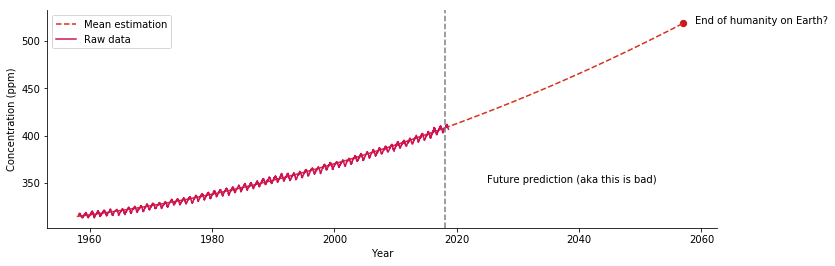

In [10]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * x * x + b * x + c

popt, pcov = curve_fit(func, data_agg.index.values, data_agg['Concentration']['mean'])
print ('Optimal parameters ', popt) #parameters
#print ('Covariance matrix ', pcov) #covariance
perr = np.sqrt(np.diag(pcov))
print ('Standard Deviation error on each parameter', perr)

year_range = np.arange(2018, 2058, 1)

f, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(data_agg.index.values, func(data_agg.index.values, popt[0], popt[1], popt[2]), c='#d7301f')
ax.plot(year_range, func(year_range, popt[0], popt[1], popt[2]), linestyle='--', c='#d7301f', label='Mean estimation')
ax.plot(dataYear, data['Concentration'], c='#ce1256', label='Raw data')
ax.axvline(x=2018, c='gray', linestyle='--')
ax.set_xlabel("Year")
ax.set_ylabel("Concentration (ppm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(2025, 350, 'Future prediction (aka this is bad)')
x = year_range[-1]
y = func(x, popt[0], popt[1], popt[2])
ax.scatter(x, y, c='#cb181d', s=40)
ax.text(x + 2, y, 'End of humanity on Earth?')
ax.legend()
plt.show()